In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.svm import l1_min_c
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
import statsmodels
warnings.filterwarnings("ignore")

In [2]:
input_file_path = "../data/"

In [3]:
data = pd.read_csv(input_file_path+"ps2_public.csv")
test = pd.read_csv(input_file_path+"ps2_kaggle_predict.csv")



# Preprocessing & Exploration

## Deal with na values and create dummy variables for categorical data

In [4]:
## the ratio between treatment 0 and 1 looks fine --> not much skewed
data["treatment"].value_counts()

1    4144
0    3356
Name: treatment, dtype: int64

In [5]:
### na values only exist in Family History column
## as the proportion of rows with nan value in family history column was not small, I decided to let it as a value of feature.
for i in data.columns:
    print(len(data[data[i].isnull()==True]))

0
0
0
0
0
2607
0
0
0
0
0
0


In [6]:
2607/7500

0.3476

In [7]:
data["family_history"].value_counts()

False    4824
True       69
Name: family_history, dtype: int64

In [8]:
### Family history False --> -1, True --> 1, nan --> 0
data = data.fillna(100)
def family_history(x):
    if x == False:
        return -1
    if x == True:
        return 1
    if x == 100:
        return 0
    else:
        print("error")
data["family_history"] = data["family_history"].apply(lambda x: family_history(x))
test["family_history"] = test["family_history"].apply(lambda x: family_history(x))

In [9]:
## Male --> 1, Female --> 0
def gender(x):
    if x == "non-female":
        return 1
    if x == "female":
        return 0
    else:
        print("error")
data["gender"] = data["gender"].apply(lambda x: gender(x))
test["gender"] = test["gender"].apply(lambda x: gender(x))

In [10]:
## Blood_test positive --> 1, negative --> 0
def blood_test(x):
    if x == "negative":
        return 0
    if x == "positive":
        return 1
    else:
        print("error")
data["blood_test"] = data["blood_test"].apply(lambda x: blood_test(x))
test["blood_test"] = test["blood_test"].apply(lambda x: blood_test(x))

In [11]:
## GeneC not active--> 0, active --> 1
def GeneC(x):
    if x == "not active":
        return 0
    if x == "active":
        return 1
    else:
        print("error")
data["GeneC"] = data["GeneC"].apply(lambda x: GeneC(x))
test["GeneC"] = test["GeneC"].apply(lambda x: GeneC(x))

In [12]:
print(data.age.max())
print(data.age.min())

93
29


# age

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcd2804be90>,
      dtype=object)

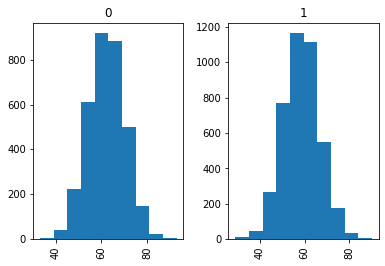

In [13]:
### histogram of age groupby treatment
data.age.hist(by=data.treatment)

treatment
0    AxesSubplot(0.125,0.125;0.352273x0.755)
1    AxesSubplot(0.125,0.125;0.352273x0.755)
Name: age, dtype: object

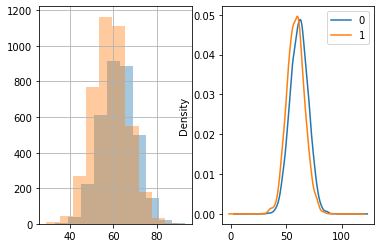

In [14]:
### histogram of age groupby treatment and kernel density estimation plot
fig, axs = plt.subplots(ncols=2)
data.groupby("treatment").age.plot(kind='kde', ax=axs[1], legend = True)
data.groupby("treatment").age.hist(alpha=0.4, ax=axs[0])

#https://stackoverflow.com/questions/21548750/plotting-histograms-against-classes-in-pandas-matplotlib

In [15]:
pval_list = []
tstat, pval, freedom = statsmodels.stats.weightstats.ttest_ind(data[data["treatment"]==0]["age"],data[data["treatment"]==1]["age"],alternative="two-sided",usevar="unequal")
pval_list.append(("age", pval))
#https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.ttest_ind.html

# Blood_Pressure

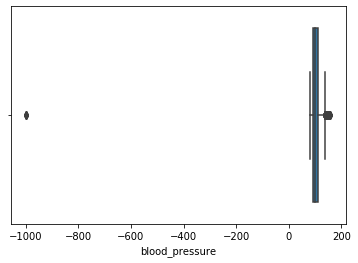

In [16]:
#### remove outliers!
sns.boxplot(x=data["blood_pressure"])

In [17]:
## -999 seems to be nan value
data[data["blood_pressure"]<0]

,treatment,age,blood_pressure,gender,blood_test,family_history,TestA,TestB,GeneC,GeneD,GeneE,GeneF
379,1,52,-999.0,0,0,-1,-0.367084,-0.125044,1,1,0,0
1539,1,59,-999.0,0,0,-1,4.776677,-0.088575,0,0,0,1
1685,1,65,-999.0,0,0,-1,4.026843,-0.122242,1,0,0,1
2123,1,51,-999.0,0,0,0,0.677114,0.047250,1,1,1,1
5773,1,68,-999.0,0,0,-1,8.524262,-0.244947,0,1,0,1
6301,0,46,-999.0,1,0,-1,-1.834005,-0.265692,0,0,1,0
6502,1,58,-999.0,0,1,-1,3.480871,0.022472,0,1,1,1


In [18]:
# change -999 blood_pressure to mean value
mean_blood_pressure = data[data.blood_pressure != -999].blood_pressure.mean()
data["blood_pressure"] = data["blood_pressure"].replace(-999,mean_blood_pressure)
test["blood_pressure"] = test["blood_pressure"].replace(-999,mean_blood_pressure)


treatment
0    AxesSubplot(0.125,0.125;0.352273x0.755)
1    AxesSubplot(0.125,0.125;0.352273x0.755)
Name: blood_pressure, dtype: object

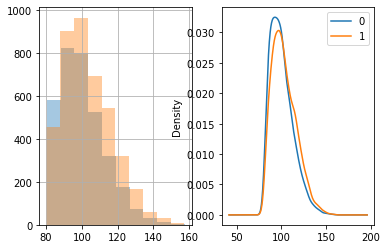

In [19]:
### histogram of age groupby treatment and kernel density estimation plot
fig, axs = plt.subplots(ncols=2)
data.groupby("treatment").blood_pressure.plot(kind='kde', ax=axs[1], legend = True)
data.groupby("treatment").blood_pressure.hist(alpha=0.4, ax=axs[0])

#https://stackoverflow.com/questions/21548750/plotting-histograms-against-classes-in-pandas-matplotlib

In [20]:
tstat, pval, freedom = statsmodels.stats.weightstats.ttest_ind(data[data["treatment"]==0]["blood_pressure"],data[data["treatment"]==1]["blood_pressure"],alternative="two-sided",usevar="unequal")
pval_list.append(("blood_pressure", pval))
print("P-value : ",pval)
#https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.ttest_ind.html

P-value :  8.596063243637039e-23


# gender

In [21]:
def stacked_barplot_btw_columns(data, col1, col2, label1, label2):##col1 : target

## count numbers
    count_gender = data[[col1,col2]].groupby([col1,col2]).size()

    male_0 = count_gender[0,1]
    male_1 = count_gender[1,1]
    female_0 = count_gender[0,0]
    female_1 = count_gender[1,0]

    treatment_1 = [male_1, female_1]
    treatment_0 = [male_0, female_0]
    width = 0.5

    p1 = plt.bar([label1, label2],[male_0,female_0])
    p2 = plt.bar([label1, label2],[male_1,female_1], bottom = [male_0,female_0])

    plt.ylabel('Count by treatment')
    plt.xlabel(col2)
    plt.legend((p1[0], p2[0]), ('Treatment 0', 'Treatment 1'))

    plt.show()

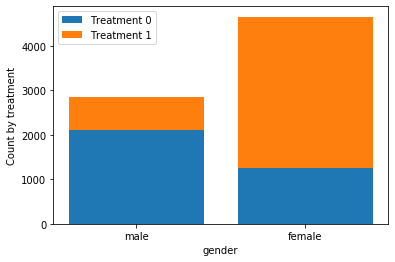

In [22]:
stacked_barplot_btw_columns(data, "treatment", "gender", "male", "female")

### Female had higher proportion of Treatment 1

In [23]:
tstat, pval, freedom = statsmodels.stats.weightstats.ttest_ind(data[data["treatment"]==0]["gender"],data[data["treatment"]==1]["gender"],alternative="two-sided",usevar="unequal")
pval_list.append(("gender", pval))
print("P-value : ",pval)
#https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.ttest_ind.html

P-value :  0.0


# Blood_test

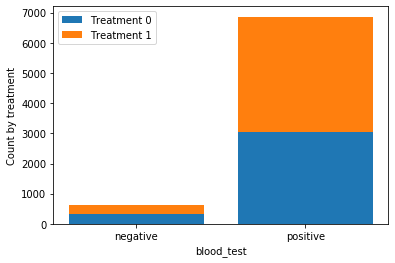

In [24]:
stacked_barplot_btw_columns(data, "treatment", "blood_test", "negative", "positive")

In [25]:
tstat, pval, freedom = statsmodels.stats.weightstats.ttest_ind(data[data["treatment"]==0]["blood_test"],data[data["treatment"]==1]["blood_test"],alternative="two-sided",usevar="unequal")
pval_list.append(("blood_test", pval))
print("P-value : ",pval)
#https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.ttest_ind.html

P-value :  0.016763878878604723


# Family_History

In [26]:
count_family_history = data[["treatment", "family_history"]].groupby(["treatment", "family_history"]).size()

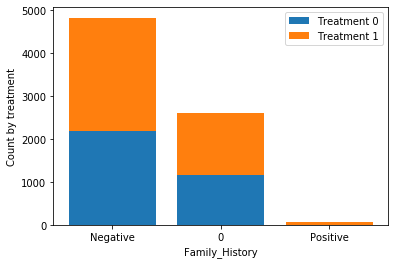

In [27]:
neg_0 = count_family_history [0,-1]
nan_0 = count_family_history [0,0]
pos_0 = count_family_history [0,1]
neg_1 = count_family_history [1,-1]
nan_1 = count_family_history [1,0]
pos_1 = count_family_history [1,1]


treatment_1 = [neg_1, nan_1, pos_1]
treatment_0 = [neg_0, nan_0, pos_0]
width = 0.5

p1 = plt.bar(["Negative", "0", "Positive"], treatment_0)
p2 = plt.bar(["Negative", "0", "Positive"], treatment_1, bottom = treatment_0)

plt.ylabel('Count by treatment')
plt.xlabel("Family_History")
plt.legend((p1[0], p2[0]), ('Treatment 0', 'Treatment 1'))

plt.show()

In [28]:
tstat, pval, freedom = statsmodels.stats.weightstats.ttest_ind(data[data["treatment"]==0]["family_history"],data[data["treatment"]==1]["family_history"],alternative="two-sided",usevar="unequal")
pval_list.append(("Family_History", pval))
print("P-value : ",pval)
#https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.ttest_ind.html

P-value :  0.008474968788835285


# TestA

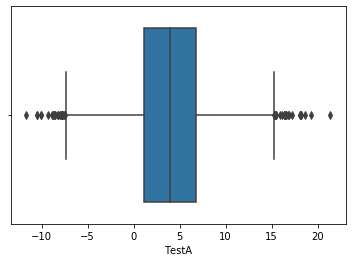

In [29]:
## Box plot
sns.boxplot(x=data["TestA"])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcd2d272350>,
      dtype=object)

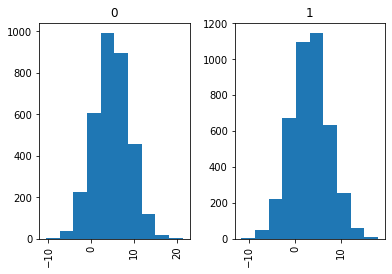

In [30]:
### histogram of TestA groupby treatment
data.TestA.hist(by=data.treatment)

treatment
0    AxesSubplot(0.125,0.125;0.352273x0.755)
1    AxesSubplot(0.125,0.125;0.352273x0.755)
Name: TestA, dtype: object

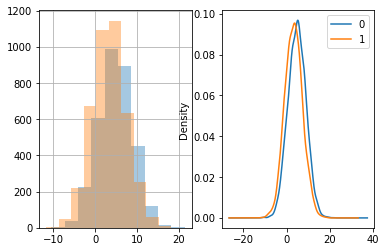

In [31]:
### histogram of TestA groupby treatment and kernel density estimation plot
fig, axs = plt.subplots(ncols=2)
data.groupby("treatment").TestA.plot(kind='kde', ax=axs[1], legend =True)
data.groupby("treatment").TestA.hist(alpha=0.4, ax=axs[0])

In [32]:
tstat, pval, freedom = statsmodels.stats.weightstats.ttest_ind(data[data["treatment"]==0]["TestA"],data[data["treatment"]==1]["TestA"],alternative="two-sided",usevar="unequal")
pval_list.append(("TestA", pval))
print("P-value : ",pval)
#https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.ttest_ind.html

P-value :  3.371280032526245e-59


# TestB

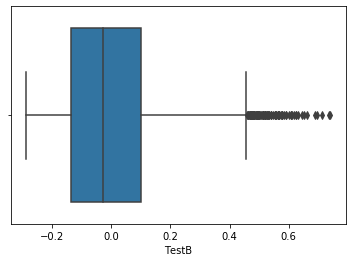

In [33]:
## Boxplot
sns.boxplot(x=data["TestB"])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcd2d709a10>,
      dtype=object)

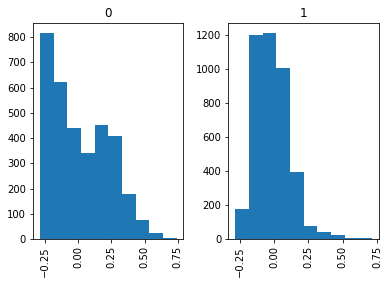

In [34]:
### histogram of TestB groupby treatment
data.TestB.hist(by=data.treatment)

treatment
0    AxesSubplot(0.125,0.125;0.352273x0.755)
1    AxesSubplot(0.125,0.125;0.352273x0.755)
Name: TestB, dtype: object

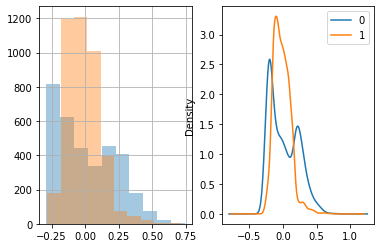

In [35]:
### histogram of TestB groupby treatment and kernel density estimation plot
fig, axs = plt.subplots(ncols=2)
data.groupby("treatment").TestB.plot(kind='kde', ax=axs[1], legend = True)
data.groupby("treatment").TestB.hist(alpha=0.4, ax=axs[0])

In [36]:
tstat, pval, freedom = statsmodels.stats.weightstats.ttest_ind(data[data["treatment"]==0]["TestB"],data[data["treatment"]==1]["TestB"],alternative="two-sided",usevar="unequal")
# pval_list.append(("TestB", pval))
print("P-value : ",pval)

P-value :  2.564103416101554e-12


In [37]:
data["TestB"] = data["TestB"].apply(lambda x : x**2)
test["TestB"] = test["TestB"].apply(lambda x : x**2)

treatment
0    AxesSubplot(0.125,0.125;0.352273x0.755)
1    AxesSubplot(0.125,0.125;0.352273x0.755)
Name: TestB, dtype: object

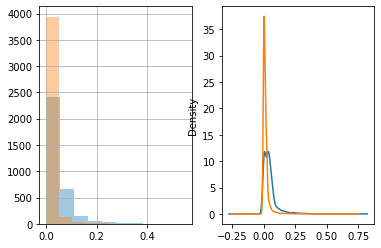

In [38]:
### histogram of TestB groupby treatment and kernel density estimation plot
fig, axs = plt.subplots(ncols=2)
data.groupby("treatment").TestB.plot(kind='kde', ax=axs[1])
data.groupby("treatment").TestB.hist(alpha=0.4, ax=axs[0])

In [39]:
tstat, pval, freedom = statsmodels.stats.weightstats.ttest_ind(data[data["treatment"]==0]["TestB"],data[data["treatment"]==1]["TestB"],alternative="two-sided",usevar="unequal")
pval_list.append(("TestB", pval))
print("P-value : ",pval)


P-value :  2.0497915520390705e-178


## Found that there is significant difference in distribution between two groups

# GeneC

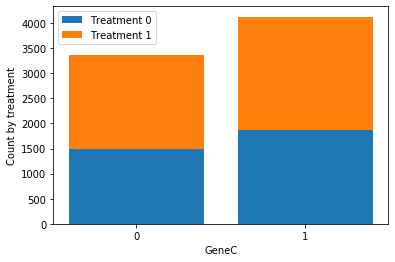

In [40]:
stacked_barplot_btw_columns(data, "treatment", "GeneC", "0", "1")

In [41]:
tstat, pval, freedom = statsmodels.stats.weightstats.ttest_ind(data[data["treatment"]==0]["GeneC"],data[data["treatment"]==1]["GeneC"],alternative="two-sided",usevar="unequal")
pval_list.append(("GeneC", pval))
print("P-value : ",pval)
#https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.ttest_ind.html

P-value :  0.44655288842904617


# GeneD

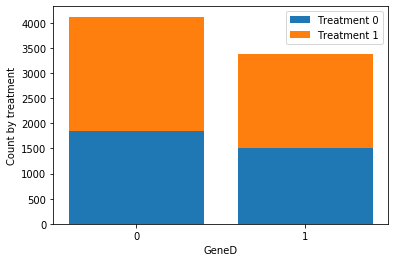

In [42]:
stacked_barplot_btw_columns(data, "treatment", "GeneD", "0", "1")

In [43]:
tstat, pval, freedom = statsmodels.stats.weightstats.ttest_ind(data[data["treatment"]==0]["GeneD"],data[data["treatment"]==1]["GeneD"],alternative="two-sided",usevar="unequal")
pval_list.append(("GeneD", pval))
print("P-value : ",pval)
#https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.ttest_ind.html

P-value :  0.6410407237875908


# GeneE

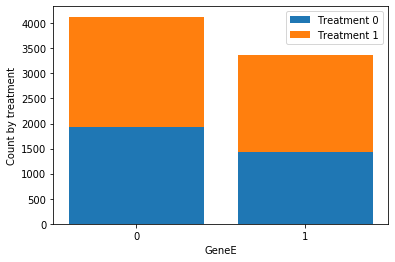

In [44]:
stacked_barplot_btw_columns(data, "treatment", "GeneE", "0", "1")

In [45]:
statsmodels.stats.weightstats.ttest_ind(data[data["treatment"]==0]["GeneE"],data[data["treatment"]==1]["GeneE"],alternative="two-sided",usevar="unequal")
pval_list.append(("GeneE", pval))
print("P-value : ",pval)
#https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.ttest_ind.html

P-value :  0.6410407237875908


# GeneF

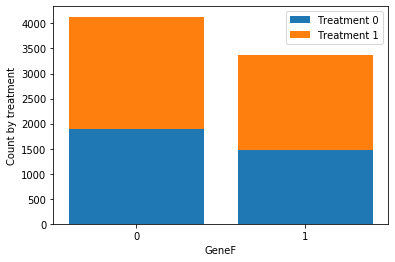

In [46]:
stacked_barplot_btw_columns(data, "treatment", "GeneF", "0", "1")

In [47]:
tstat, pval, freedom = statsmodels.stats.weightstats.ttest_ind(data[data["treatment"]==0]["GeneF"],data[data["treatment"]==1]["GeneF"],alternative="two-sided",usevar="unequal")
pval_list.append(("GeneF", pval))
print("P-value : ",pval)
#https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.ttest_ind.html

P-value :  0.06728879970716177


In [48]:
p_val = pd.DataFrame(pval_list, columns = ["feature", "p_val"]).sort_values(by = "p_val", ascending = False)
p_val

,feature,p_val
8,GeneD,6.410407e-01
9,GeneE,6.410407e-01
7,GeneC,4.465529e-01
10,GeneF,6.728880e-02
3,blood_test,1.676388e-02
4,Family_History,8.474969e-03
1,blood_pressure,8.596063e-23
5,TestA,3.371280e-59
0,age,1.856751e-63
6,TestB,2.049792e-178


In [49]:
p_val[p_val["p_val"]>0.1]

,feature,p_val
8,GeneD,0.641041
9,GeneE,0.641041
7,GeneC,0.446553


## GeneD, GeneE, GeneC are not informative since pvalue of ttest is larger than 0.1
## pvalue of GeneF is larger than 0.05

In [50]:
data.corr()

,treatment,age,blood_pressure,gender,blood_test,family_history,TestA,TestB,GeneC,GeneD,GeneE,GeneF
treatment,1.000000,-0.192643,0.112379,-0.457285,-0.027859,0.030165,-0.185840,-0.340274,0.008789,-0.005384,-0.044184,-0.021119
age,-0.192643,1.000000,0.005736,-0.007886,-0.013876,-0.024855,0.969773,-0.012216,-0.006479,0.002007,0.015119,-0.013572
blood_pressure,0.112379,0.005736,1.000000,-0.000064,0.009421,0.009939,0.004834,0.020739,0.004219,0.008332,-0.003861,-0.004006
gender,-0.457285,-0.007886,-0.000064,1.000000,-0.009414,0.007741,-0.009346,0.025504,-0.009414,-0.013633,-0.008340,-0.006969
blood_test,-0.027859,-0.013876,0.009421,-0.009414,1.000000,-0.006826,-0.013463,0.024082,0.024535,-0.016351,0.008870,-0.004918
family_history,0.030165,-0.024855,0.009939,0.007741,-0.006826,1.000000,-0.025380,0.005320,0.024895,0.013234,0.003974,0.001583
TestA,-0.185840,0.969773,0.004834,-0.009346,-0.013463,-0.025380,1.000000,-0.012091,-0.004774,0.004863,0.016239,-0.014315
TestB,-0.340274,-0.012216,0.020739,0.025504,0.024082,0.005320,-0.012091,1.000000,-0.016952,-0.003177,-0.007520,0.003457
GeneC,0.008789,-0.006479,0.004219,-0.009414,0.024535,0.024895,-0.004774,-0.016952,1.000000,0.008430,-0.001292,0.009055
GeneD,-0.005384,0.002007,0.008332,-0.013633,-0.016351,0.013234,0.004863,-0.003177,0.008430,1.000000,0.006305,0.011048


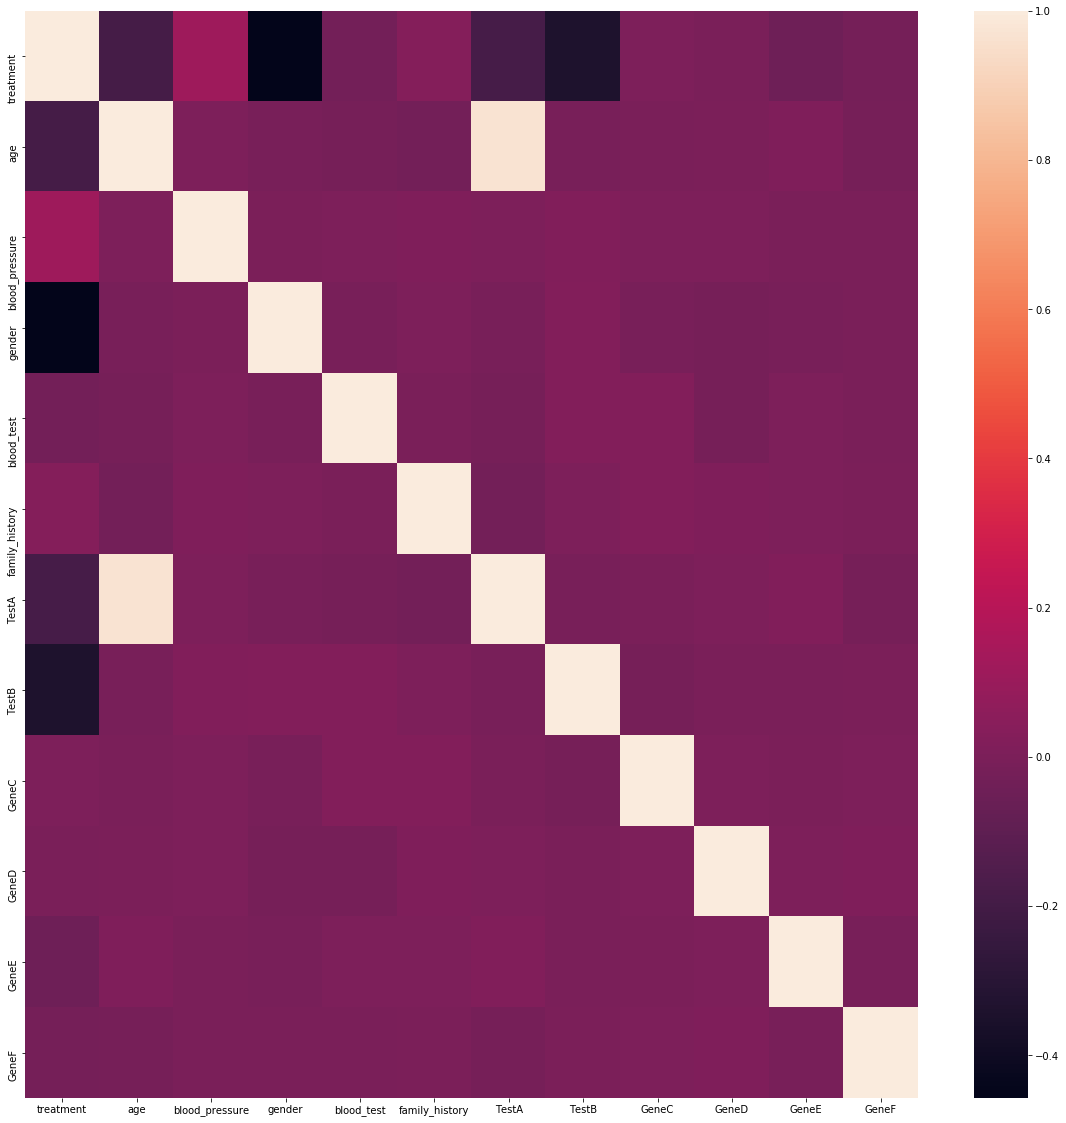

In [51]:
## correlation heatmap of data

f, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(data.corr())

#https://seaborn.pydata.org/generated/seaborn.heatmap.html

# train, validation, test split

In [52]:
data

,treatment,age,blood_pressure,gender,blood_test,family_history,TestA,TestB,GeneC,GeneD,GeneE,GeneF
0,0,64,103.820809,1,0,-1,4.334376,0.105218,0,1,1,0
1,0,52,107.071369,0,0,-1,0.361847,0.045375,1,1,0,0
2,1,55,113.116130,0,1,-1,3.611842,0.005147,0,0,0,1
3,0,45,83.760932,0,0,0,-5.282537,0.056226,1,0,0,0
4,0,58,131.135933,0,0,-1,2.787207,0.038208,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
7495,1,56,99.640132,0,1,-1,2.442280,0.003927,1,0,1,1
7496,1,42,87.712685,0,0,-1,-6.010248,0.011259,0,0,1,0
7497,1,49,95.136721,0,0,0,-0.196411,0.008007,0,1,0,0
7498,1,44,102.552413,0,0,0,-4.116299,0.001477,0,0,0,1


In [53]:
## Split Train, Test data
## allocate predictors to X
X = data.iloc[:,1:]

## allocate test value to y
y = data["treatment"]

In [54]:
## Train, validation, test split applying random state
## Train : Validation : Test = 8:1:1
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=1)


## https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn

# train logistic regression model

In [55]:
logistic = sm.Logit(y_train, X_train).append.fit()

AttributeError: 'Logit' object has no attribute 'append'

In [ ]:
print(logistic.summary()) 

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_train.append(X_val), y_train.append(y_val))

In [ ]:
y_pred = clf.predict(X_test)

In [148]:
confusion_mat = confusion_matrix(y_test, y_pred)

In [149]:
tn, fp, fn, tp = confusion_mat.ravel()
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

In [150]:
confusion_mat

array([[237, 108],
       [ 72, 333]])

In [151]:
f1 = tp/(tp+0.5*(fp+fn))

precision = tp/(tp+fp)

accuracy = (tp+tn)/(tp+tn+fn+fp)

In [152]:
print("F1 Score  : ", f1)
print("Precision : ", precision)
print("Accuracy  : ", accuracy)

F1 Score  :  0.7872340425531915
Precision :  0.7551020408163265
Accuracy  :  0.76


# L1 regularization

In [87]:
clf = linear_model.LogisticRegression(penalty='l1',  solver='liblinear')

coefs_ = []
best_f1 = -10**10
best_precision = -10**10
best_accuracy = -10**10
best_c = 10*10

auc_list = []
param_list = []

parameters = np.arange(1,100,1)
for param in parameters:
    clf.set_params(C=param)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    confusion_mat = confusion_matrix(y_val, y_pred)
    tn, fp, fn, tp = confusion_mat.ravel()
    accuracy = (tp+tn)/(tp+tn+fn+fp)
    auc_list.append(accuracy)
    param_list.append(param)
    if accuracy>best_accuracy:
        best_accuracy = accuracy
        best_param = param
print("best parameter : ",best_param)
print("Accuracy : ", best_accuracy)
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_path.html  

best parameter :  30
Accuracy :  0.8044444444444444


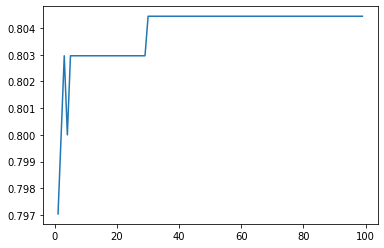

In [88]:
plt.plot(param_list, auc_list)

In [89]:
clf = linear_model.LogisticRegression(penalty='l1',  solver='liblinear')


best_f1 = -10**10
best_precision = -10**10
best_accuracy = -10**10
best_c = 10*10

auc_list = []
f1_list = []
precision_list = []
param_list = []

parameters = np.arange(20,31,0.01)
for param in parameters:
    clf.set_params(C=param)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    confusion_mat = confusion_matrix(y_val, y_pred)
    tn, fp, fn, tp = confusion_mat.ravel()
    
    f1 = tp/(tp+0.5*(fp+fn))
    precision = tp/(tp+fp)
    accuracy = (tp+tn)/(tp+tn+fn+fp)
    
    auc_list.append(accuracy)
    f1_list.append(f1)
    precision_list.append(precision)
    param_list.append(param)
    
    if accuracy>best_accuracy:
        best_accuracy = accuracy
        best_auc_param = param
        
    if f1>best_f1:
        best_f1 = f1
        best_f1param = param
        
    if precision>best_precision:
        best_precision = precision
        best_precision_param = param
     

KeyboardInterrupt: 

In [ ]:
print("best auc parameter : ",best_auc_param)
print("Accuracy : ", best_accuracy)
print()
print("best f1 parameter : ",best_f1param)
print("F1 : ", best_f1)
print()
print("best precisioin parameter : ",best_precision_param)
print("Precision : ", best_precision)
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_path.html  

In [ ]:
plt.plot(param_list, auc_list)
plt.xlabel("param")
plt.ylabel("AUC")

In [ ]:
plt.plot(param_list, f1_list)
plt.xlabel("param")
plt.ylabel("F1 Score")

In [ ]:
plt.plot(param_list, precision_list)
plt.xlabel("param")
plt.ylabel("Precision")

In [310]:
clf = linear_model.LogisticRegression(penalty='l1',  solver='liblinear')
clf.set_params(C=0.56)
clf.fit(X_train.append(X_val), y_train.append(y_val))
y_pred = clf.predict(X_test)

confusion_mat = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_mat.ravel()

f1 = tp/(tp+0.5*(fp+fn))
precision = tp/(tp+fp)
accuracy = (tp+tn)/(tp+tn+fn+fp)

In [311]:
print("F1 Score  : ", f1)
print("Precision : ", precision)
print("Accuracy  : ", accuracy)

F1 Score  :  0.8186274509803921
Precision :  0.8126520681265207
Accuracy  :  0.8026666666666666


In [312]:
yhat = clf.predict_proba(X_test)

pos_probs = yhat[:, 1]

print('roc_auc score : ', roc_auc_score(y_test, pos_probs))

roc_auc score :  0.8915369475755949


# Feature selected

In [153]:
data.columns

Index(['treatment', 'age', 'blood_pressure', 'gender', 'blood_test',
       'family_history', 'TestA', 'TestB', 'GeneC', 'GeneD', 'GeneE', 'GeneF'],
      dtype='object')

In [154]:
test

,Id,age,blood_pressure,gender,blood_test,family_history,TestA,TestB,GeneC,GeneD,GeneE,GeneF
0,0,53,115.102446,1,1,-1,-0.021825,0.037783,1,1,0,1
1,1,64,128.260954,0,0,-1,7.678080,0.037938,0,1,0,1
2,2,60,94.202505,0,0,-1,2.476105,0.011213,1,1,0,0
3,3,61,101.630800,0,0,-1,3.497286,0.034656,0,1,1,1
4,4,69,120.710802,1,0,-1,9.781353,0.018351,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
7495,7495,46,110.536559,0,0,-1,-1.987730,0.045739,0,0,1,1
7496,7496,66,94.140814,0,0,-1,7.635846,0.001908,0,0,1,0
7497,7497,56,100.499343,0,0,-1,1.861948,0.015028,0,0,1,1
7498,7498,64,99.181979,0,0,-1,5.846495,0.034161,1,1,0,1


In [156]:
fselected_data = data[['treatment', 'age', 'blood_pressure', 'gender', 'blood_test','family_history', 'TestB', 'GeneE', 'GeneF']]
test = test[["Id", 'age', 'blood_pressure', 'gender', 'blood_test','family_history', 'TestB', 'GeneE', 'GeneF']]


In [157]:
## Split Train, Test data
## allocate predictors to X
X = fselected_data.iloc[:,1:]

## allocate test value to y
y = fselected_data["treatment"]

## Train, validation, test split applying random state
## Train : Validation : Test = 8:1:1
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=1)

## https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn

# Baseline logistic regression

In [160]:
logistic = sm.Logit(y_train, X_train).fit()
print(logistic.summary()) 

Optimization terminated successfully.
         Current function value: 0.441828
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              treatment   No. Observations:                 6750
Model:                          Logit   Df Residuals:                     6742
Method:                           MLE   Df Model:                            7
Date:                Thu, 18 Feb 2021   Pseudo R-squ.:                  0.3572
Time:                        17:54:35   Log-Likelihood:                -2982.3
converged:                       True   LL-Null:                       -4639.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
age               -0.0493      0.003    -15.820      0.000      -0.055      -0.043
blood_pressure   

In [162]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)


In [163]:
y_pred = clf.predict(X_test)

confusion_mat = confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = confusion_mat.ravel()
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

confusion_mat

f1 = tp/(tp+0.5*(fp+fn))

precision = tp/(tp+fp)

accuracy = (tp+tn)/(tp+tn+fn+fp)

print("F1 Score  : ", f1)
print("Precision : ", precision)
print("Accuracy  : ", accuracy)

F1 Score  :  0.7688679245283019
Precision :  0.7358916478555305
Accuracy  :  0.7386666666666667


# L1 regularization

In [167]:
clf = linear_model.LogisticRegression(penalty='l1',  solver='liblinear')

coefs_ = []
best_f1 = -10**10
best_precision = -10**10
best_accuracy = -10**10
best_c = 10*10

auc_list = []
param_list = []

parameters = np.arange(1,100,1)
for param in parameters:
    clf.set_params(C=param)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    confusion_mat = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = confusion_mat.ravel()
    accuracy = (tp+tn)/(tp+tn+fn+fp)
    auc_list.append(accuracy)
    param_list.append(param)
    if accuracy>best_accuracy:
        best_accuracy = accuracy
        best_param = param
print("best parameter : ",best_param)
print("Accuracy : ", best_accuracy)
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_path.html  

best parameter :  2
Accuracy :  0.808


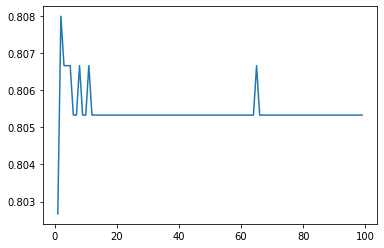

In [168]:
plt.plot(param_list, auc_list)

In [170]:
clf = linear_model.LogisticRegression(penalty='l1',  solver='liblinear')


best_f1 = -10**10
best_precision = -10**10
best_accuracy = -10**10
best_c = 10*10

auc_list = []
f1_list = []
precision_list = []
param_list = []

parameters = np.arange(1,3,0.01)
for param in parameters:
    clf.set_params(C=param)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    confusion_mat = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = confusion_mat.ravel()
    
    f1 = tp/(tp+0.5*(fp+fn))
    precision = tp/(tp+fp)
    accuracy = (tp+tn)/(tp+tn+fn+fp)
    
    auc_list.append(accuracy)
    f1_list.append(f1)
    precision_list.append(precision)
    param_list.append(param)
    
    if accuracy>best_accuracy:
        best_accuracy = accuracy
        best_auc_param = param
        
    if f1>best_f1:
        best_f1 = f1
        best_f1param = param
        
    if precision>best_precision:
        best_precision = precision
        best_precision_param = param
     

In [171]:
print("best auc parameter : ",best_auc_param)
print("Accuracy : ", best_accuracy)
print()
print("best f1 parameter : ",best_f1param)
print("F1 : ", best_f1)
print()
print("best precisioin parameter : ",best_precision_param)
print("Precision : ", best_precision)
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_path.html  

best auc parameter :  1.5400000000000005
Accuracy :  0.808

best f1 parameter :  1.5400000000000005
F1 :  0.8230958230958231

best precisioin parameter :  1.5400000000000005
Precision :  0.8190709046454768


Text(0, 0.5, 'AUC')

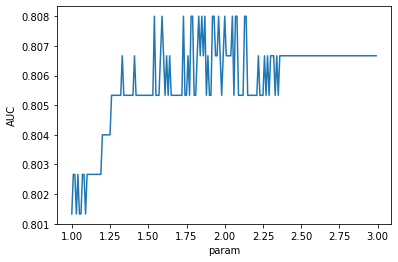

In [172]:
plt.plot(param_list, auc_list)
plt.xlabel("param")
plt.ylabel("AUC")

Text(0, 0.5, 'F1 Score')

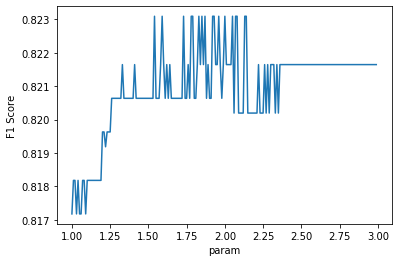

In [173]:
plt.plot(param_list, f1_list)
plt.xlabel("param")
plt.ylabel("F1 Score")

Text(0, 0.5, 'Precision')

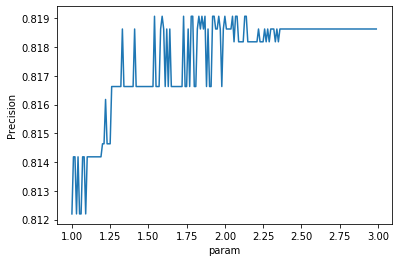

In [174]:
plt.plot(param_list, precision_list)
plt.xlabel("param")
plt.ylabel("Precision")

# final model

In [176]:
clf = linear_model.LogisticRegression(penalty='l1',  solver='liblinear')
clf.set_params(C=1.54)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

confusion_mat = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_mat.ravel()

f1 = tp/(tp+0.5*(fp+fn))
precision = tp/(tp+fp)
accuracy = (tp+tn)/(tp+tn+fn+fp)

print("F1 Score  : ", f1)
print("Precision : ", precision)
print("Accuracy  : ", accuracy)

yhat = clf.predict_proba(X_test)

pos_probs = yhat[:, 1]

print('roc_auc score : ', roc_auc_score(y_test, pos_probs))

F1 Score  :  0.8206388206388207
Precision :  0.8166259168704156
Accuracy  :  0.8053333333333333
roc_auc score :  0.892474503488996


In [182]:
test.iloc[:,1:]

,age,blood_pressure,gender,blood_test,family_history,TestB,GeneE,GeneF
0,53,115.102446,1,1,-1,0.037783,0,1
1,64,128.260954,0,0,-1,0.037938,0,1
2,60,94.202505,0,0,-1,0.011213,0,0
3,61,101.630800,0,0,-1,0.034656,1,1
4,69,120.710802,1,0,-1,0.018351,1,1
...,...,...,...,...,...,...,...,...
7495,46,110.536559,0,0,-1,0.045739,1,1
7496,66,94.140814,0,0,-1,0.001908,1,0
7497,56,100.499343,0,0,-1,0.015028,1,1
7498,64,99.181979,0,0,-1,0.034161,0,1


In [183]:
clf = linear_model.LogisticRegression(penalty='l1',  solver='liblinear')
clf.set_params(C=1.54)
clf.fit(X_train.append(X_test), y_train.append(y_test))
y_pred = clf.predict(test.iloc[:,1:])



In [187]:
result =pd.DataFrame()

result["Id"] = test.iloc[:,0]

result["predicted"] = y_pred

result = result.set_index("Id")

result.to_csv("submission.csv")

In [189]:
import lightgbm as lgb

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 100,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [61]:
import lightgbm as lgb
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 10000,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,
                early_stopping_rounds=20)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_logloss: 0.659456
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's binary_logloss: 0.647382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's binary_logloss: 0.620679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's binary_logloss: 0.59697
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's binary_logloss: 0.577147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's binary_logloss: 0.568864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's bi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[72]	valid_0's binary_logloss: 0.265923
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[73]	valid_0's binary_logloss: 0.265949
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[74]	valid_0's binary_logloss: 0.265136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[75]	valid_0's binary_logloss: 0.265047
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[76]	valid_0's binary_logloss: 0.264965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[77]	valid_0's binary_logloss: 0.263027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[78]	valid_0's binary_logloss: 0.261616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[79]	valid_0's binary_logloss: 0.261177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	

In [62]:
predictions = gbm.predict(test.iloc[:,1:], num_iteration=gbm.best_iteration)

In [63]:
predictions

array([0.01045207, 0.54181995, 0.97918386, ..., 0.99162269, 0.08592216,
       0.24615946])

In [64]:
def ftn(x):
    if x>=0.5:
        return 1
    else:
        return 0
predictions = [ftn(x) for x in predictions]

In [65]:
result =pd.DataFrame()

result["Id"] = test.iloc[:,0]

result["predicted"] = predictions

result = result.set_index("Id")

result.to_csv("submission.csv")

In [67]:
X_train

,age,blood_pressure,gender,blood_test,family_history,TestA,TestB,GeneC,GeneD,GeneE,GeneF
1167,72,104.178442,0,0,0,8.128177,0.031841,0,1,1,1
6595,59,89.794172,0,0,-1,3.787263,0.033189,0,1,1,1
2688,60,109.017037,1,0,0,5.629395,0.004681,1,1,0,1
5631,60,94.118508,0,0,0,1.862399,0.028322,0,1,0,1
6236,55,85.029496,0,0,0,0.737072,0.006219,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
905,57,92.323169,0,1,0,3.320676,0.015909,0,0,0,0
5192,58,100.156229,1,0,-1,4.222863,0.052408,1,1,0,0
3980,63,92.940286,1,0,-1,5.817644,0.021791,0,0,0,1
235,60,94.898685,1,0,0,5.184291,0.293670,1,1,1,1


In [56]:

import h2o
from h2o.automl import H2OAutoMLh2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_282"; OpenJDK Runtime Environment (AdoptOpenJDK)(build 1.8.0_282-b08); OpenJDK 64-Bit Server VM (AdoptOpenJDK)(build 25.282-b08, mixed mode)
  Starting server from /Users/jaeyoungkim/.local/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/27/fcv785895zb4wczv3dzgn3gh0000gn/T/tmp7tf_e9va
  JVM stdout: /var/folders/27/fcv785895zb4wczv3dzgn3gh0000gn/T/tmp7tf_e9va/h2o_jaeyoungkim_started_from_python.out
  JVM stderr: /var/folders/27/fcv785895zb4wczv3dzgn3gh0000gn/T/tmp7tf_e9va/h2o_jaeyoungkim_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Asia/Seoul
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.4
H2O_cluster_version_age:,24 days
H2O_cluster_name:,H2O_from_python_jaeyoungkim_yzc4ga
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.556 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


In [ ]:
# # Use local data file or download from GitHub
# import os
# docker_data_path = "/home/h2o/data/automl/product_backorders.csv"
# if os.path.isfile(docker_data_path):
#     data_path = docker_data_path
# else:
#     data_path = "https://github.com/h2oai/h2o-tutorials/raw/master/h2o-world-2017/automl/data/product_backorders.csv"

In [63]:
# Load data into H2O
df = h2o.import_file("exercise.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [64]:
df.describe()

Rows:7500
Cols:13




,C1,treatment,age,blood_pressure,gender,blood_test,family_history,TestA,TestB,GeneC,GeneD,GeneE,GeneF
type,int,int,int,real,int,int,int,real,real,int,int,int,int
mins,0.0,0.0,29.0,80.09911354140809,0.0,0.0,-1.0,-11.699343936385878,8.867280077920975e-12,0.0,0.0,0.0,0.0
mean,3749.5,0.5525333333333333,59.978,102.05155824183768,0.3792,0.08493333333333333,-0.634,3.983447985872346,0.0294085271122937,0.4497333333333333,0.5494666666666667,0.5506666666666666,0.5512
maxs,7499.0,1.0,93.0,157.47122574760553,1.0,1.0,1.0,21.38641208569021,0.5486647807612153,1.0,1.0,1.0,1.0
sigma,2165.2078422174627,0.4972657424872296,8.100115076254564,13.217883677853413,0.48522031267618815,0.27880105133539035,0.500477169295728,4.1623431382848235,0.04484435669986805,0.4975000131229109,0.4975802049555469,0.49745942984341374,0.4974048132119627
zeros,1,3356,0,0,4656,6863,2607,0,0,4127,3379,3370,3366
missing,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0.0,0.0,64.0,103.8208093474858,1.0,0.0,-1.0,4.334376450662521,0.10521830868268284,0.0,1.0,1.0,0.0
1,1.0,0.0,52.0,107.07136911578507,0.0,0.0,-1.0,0.3618465795010217,0.04537481472722,1.0,1.0,0.0,0.0
2,2.0,1.0,55.0,113.11612967856156,0.0,1.0,-1.0,3.6118421272336696,0.0051466523655637805,0.0,0.0,0.0,1.0


In [65]:

y = "treatment"
x = df.columns
x.remove(y)
# x.remove("sku")

In [66]:
aml = H2OAutoML(max_models = 10, seed = 1)
aml.train(x = x, y = y, training_frame = df)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [67]:
lb = aml.leaderboard

In [68]:
lb.head()

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20210226_001534,0.0792566,0.281525,0.0792566,0.191054,0.19825
StackedEnsemble_BestOfFamily_AutoML_20210226_001534,0.0799268,0.282713,0.0799268,0.18835,0.198911
GBM_3_AutoML_20210226_001534,0.0806908,0.284061,0.0806908,0.195885,0.20081
GBM_5_AutoML_20210226_001534,0.0820743,0.286486,0.0820743,0.203103,0.202331
GBM_2_AutoML_20210226_001534,0.0825213,0.287265,0.0825213,0.198284,0.202206
GBM_1_AutoML_20210226_001534,0.0830446,0.288175,0.0830446,0.20021,0.203517
GBM_4_AutoML_20210226_001534,0.0838084,0.289497,0.0838084,0.197994,0.204292
DRF_1_AutoML_20210226_001534,0.0864405,0.294008,0.0864405,0.189574,0.206641
XGBoost_3_AutoML_20210226_001534,0.0901842,0.300307,0.0901842,0.219135,0.212727
XGBoost_1_AutoML_20210226_001534,0.0999686,0.316178,0.0999686,0.22433,0.22401


In [69]:
lb.head(rows=lb.nrows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20210226_001534,0.0792566,0.281525,0.0792566,0.191054,0.19825
StackedEnsemble_BestOfFamily_AutoML_20210226_001534,0.0799268,0.282713,0.0799268,0.18835,0.198911
GBM_3_AutoML_20210226_001534,0.0806908,0.284061,0.0806908,0.195885,0.20081
GBM_5_AutoML_20210226_001534,0.0820743,0.286486,0.0820743,0.203103,0.202331
GBM_2_AutoML_20210226_001534,0.0825213,0.287265,0.0825213,0.198284,0.202206
GBM_1_AutoML_20210226_001534,0.0830446,0.288175,0.0830446,0.20021,0.203517
GBM_4_AutoML_20210226_001534,0.0838084,0.289497,0.0838084,0.197994,0.204292
DRF_1_AutoML_20210226_001534,0.0864405,0.294008,0.0864405,0.189574,0.206641
XGBoost_3_AutoML_20210226_001534,0.0901842,0.300307,0.0901842,0.219135,0.212727
XGBoost_1_AutoML_20210226_001534,0.0999686,0.316178,0.0999686,0.22433,0.22401


In [70]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])

/Users/jaeyoungkim/.local/lib/python3.7/site-packages/h2o/estimators/stackedensemble.py:821: H2ODeprecationWarning: The usage of stacked_ensemble.metalearner()['name'] will be deprecated. Metalearner now returns the metalearner object. If you need to get the 'name' please use stacked_ensemble.metalearner().model_id
  H2ODeprecationWarning


In [71]:
metalearner.coef_norm()

{'Intercept': 0.5525333333333334,
 'GBM_3_AutoML_20210226_001534': 0.1606993092862077,
 'GBM_5_AutoML_20210226_001534': 0.09402395883728289,
 'GBM_2_AutoML_20210226_001534': 0.030251924278162968,
 'GBM_1_AutoML_20210226_001534': 0.056002347189450734,
 'GBM_4_AutoML_20210226_001534': 0.03676438227766428,
 'DRF_1_AutoML_20210226_001534': 0.03084001777416907,
 'XGBoost_3_AutoML_20210226_001534': 0.0,
 'XGBoost_1_AutoML_20210226_001534': 0.004889666896224253,
 'XGBoost_2_AutoML_20210226_001534': 0.0,
 'GLM_1_AutoML_20210226_001534': 0.0}

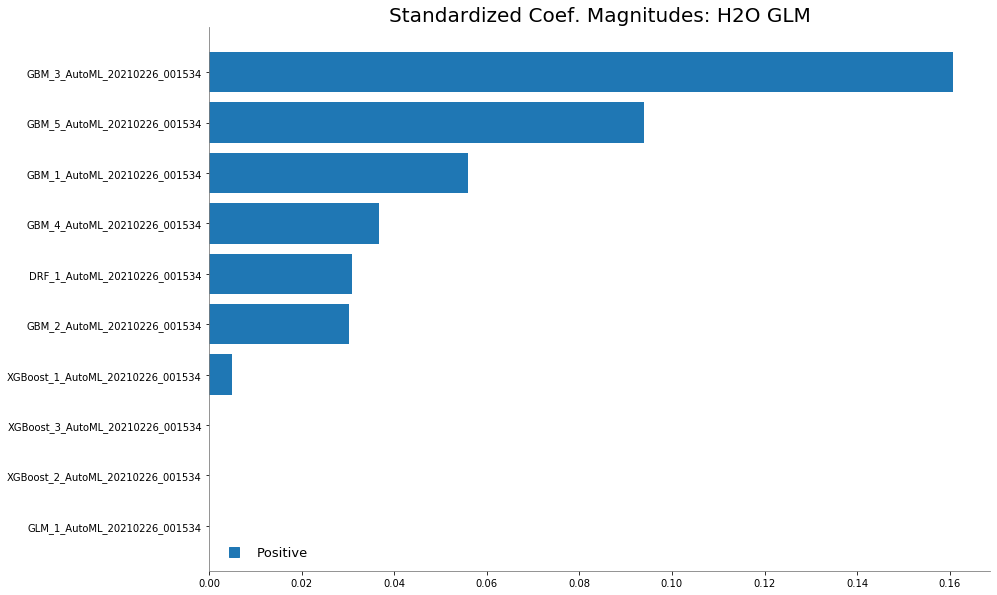

In [72]:

%matplotlib inline
metalearner.std_coef_plot()

In [73]:
h2o.save_model(aml.leader, path = "./product_backorders_model_bin")

'/Users/jaeyoungkim/Desktop/usc/DSCI - 552/hw2/code/product_backorders_model_bin/StackedEnsemble_AllModels_AutoML_20210226_001534'

In [74]:
aml.leader.download_mojo(path = "./")

'/Users/jaeyoungkim/Desktop/usc/DSCI - 552/hw2/code/StackedEnsemble_AllModels_AutoML_20210226_001534.zip'

In [75]:
aml.leader.predict

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20210226_001534

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.038942966478797796
RMSE: 0.19733972351961426
MAE: 0.13173401302103105
RMSLE: 0.14071044271516095
R^2: 0.842489373579708
Mean Residual Deviance: 0.038942966478797796
Null degrees of freedom: 7499
Residual degrees of freedom: 7492
Null deviance: 1854.3018666666628
Residual deviance: 292.07224859098346
AIC: -3040.350260776932

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.07925657529532551
RMSE: 0.28152544342443636
MAE: 0.19105359930478777
RMSLE: 0.19824971450759046
R^2: 0.679434980139727
Mean Residual Deviance: 0.07925657529532551
Null degrees of freedom: 7499
Residual degrees of freedom: 7492
Null deviance: 1854.7392333679504
Residual deviance: 594.4243147149414
AIC: 2289.0912432678633


In [77]:
data.to_csv("train.csv")
test.to_csv("test.csv")

In [130]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()


# Import a sample binary outcome train/test set into H2O
# train = h2o.import_file("train.csv")
# test = h2o.import_file("test.csv")

train = h2o.import_file(input_file_path+"ps2_public.csv")

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,43 mins 47 secs
H2O_cluster_timezone:,Asia/Seoul
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.4
H2O_cluster_version_age:,24 days
H2O_cluster_name:,H2O_from_python_jaeyoungkim_yzc4ga
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.417 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [129]:
test = pd.read_csv(input_file_path+"ps2_kaggle_predict.csv")

In [123]:
test

,Id,age,blood_pressure,gender,blood_test,family_history,TestA,TestB,GeneC,GeneD,GeneE,GeneF
0,0,53,115.102446,non-female,positive,False,-0.021825,-0.194379,active,1,0,1
1,1,64,128.260954,female,negative,False,7.678080,0.194778,not active,1,0,1
2,2,60,94.202505,female,negative,False,2.476105,-0.105892,active,1,0,0
3,3,61,101.630800,female,negative,False,3.497286,0.186162,not active,1,1,1
4,4,69,120.710802,non-female,negative,False,9.781353,-0.135467,active,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
7495,7495,46,110.536559,female,negative,False,-1.987730,-0.213866,not active,0,1,1
7496,7496,66,94.140814,female,negative,False,7.635846,0.043677,not active,0,1,0
7497,7497,56,100.499343,female,negative,False,1.861948,0.122588,not active,0,1,1
7498,7498,64,99.181979,female,negative,False,5.846495,-0.184827,active,1,0,1


In [126]:
test.iloc[:,1:].to_csv("test1.csv")

In [131]:
test = h2o.import_file("test1.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [115]:
# Identify predictors and response
x = train.columns
y = "treatment"
x.remove(y)

In [116]:
# For binary classification, response should be a factor
train[y] = train[y].asfactor()
# test[y] = test[y].asfactor()

In [155]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, seed=2)
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [156]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_BestOfFamily_AutoML_20210226_010854,0.0717546,0.26787,0.0717546,0.162062,0.187906
StackedEnsemble_AllModels_AutoML_20210226_010854,0.0717551,0.267871,0.0717551,0.16371,0.188089
DeepLearning_grid__2_AutoML_20210226_010854_model_1,0.0788601,0.28082,0.0788601,0.190818,0.193843
GBM_2_AutoML_20210226_010854,0.0798043,0.282497,0.0798043,0.193949,0.199431
DRF_1_AutoML_20210226_010854,0.0809793,0.284569,0.0809793,0.188429,0.200824
GBM_4_AutoML_20210226_010854,0.0812826,0.285101,0.0812826,0.191691,0.201292
GBM_3_AutoML_20210226_010854,0.0832838,0.288589,0.0832838,0.20021,0.204207
XGBoost_grid__1_AutoML_20210226_010854_model_4,0.0842269,0.290219,0.0842269,0.179148,0.204027
GBM_1_AutoML_20210226_010854,0.0843317,0.290399,0.0843317,0.20696,0.205701
GBM_grid__1_AutoML_20210226_010854_model_2,0.0848215,0.291241,0.0848215,0.211912,0.205086


In [161]:

aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_AutoML_20210226_010854

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.039151899070221846
RMSE: 0.19786838825396502
MAE: 0.11444638306832418
RMSLE: 0.13875784860863316
R^2: 0.8416443146042256
Mean Residual Deviance: 0.039151899070221846
Null degrees of freedom: 7499
Residual degrees of freedom: 7495
Null deviance: 1854.301866666663
Residual deviance: 293.63924302666385
AIC: -3006.2196282873324

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.07175455955074916
RMSE: 0.26787041559446084
MAE: 0.16206198352264117
RMSLE: 0.18790632460241294
R^2: 0.7097779998474437
Mean Residual Deviance: 0.07175455955074916
Null degrees of freedom: 7499
Residual degrees of freedom: 7495
Null deviance: 1854.5023729795173
Residual deviance: 538.1591966306187
AIC: 1537.2989084512458


In [ ]:
# To generate predictions on a test set, you can make predictions
# directly on the `"H2OAutoML"` object or on the leader model
# object directly
preds = aml.predict(test)

# or:
preds = aml.leader.predict(test)

In [158]:
## 앙상블

# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])

In [162]:
preds = aml.leader.predict(test)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [167]:
preds = se.predict(test)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [168]:
h2o.as_list(preds)["predict"]

0       0.121732
1       0.457748
2       0.931138
3       0.193886
4       0.041292
          ...   
7495    0.300308
7496    0.909554
7497    0.992855
7498    0.301197
7499    0.088618
Name: predict, Length: 7500, dtype: float64

In [169]:
h2o.as_list(preds)["predict"]

0       0.121732
1       0.457748
2       0.931138
3       0.193886
4       0.041292
          ...   
7495    0.300308
7496    0.909554
7497    0.992855
7498    0.301197
7499    0.088618
Name: predict, Length: 7500, dtype: float64

In [170]:
def ftn(x):
    if x>=0.5:
        return 1
    else:
        return 0
predictions = [ftn(x) for x in h2o.as_list(preds)["predict"]]

In [171]:
a = pd.read_csv(input_file_path+"ps2_kaggle_predict.csv")

result =pd.DataFrame()

result["Id"] = a.iloc[:,0]

# result["predicted"] = h2o.as_list(preds)["predict"]
result["predicted"] = predictions

result = result.set_index("Id")

result.to_csv("submission_automl.csv")

In [104]:
a = pd.read_csv(input_file_path+"ps2_kaggle_predict.csv")

In [105]:
a.iloc[:,0]

0          0
1          1
2          2
3          3
4          4
        ... 
7495    7495
7496    7496
7497    7497
7498    7498
7499    7499
Name: Id, Length: 7500, dtype: int64